# Starbucks Capstone (predict next purchase time)

# Class redistribution
We've copied the previous notebook and will make changes along the way as needed. Since our model doesn't seem to predict the middle class very well, we'll take another look at the distribution of the next_purchase variable and maybe widen each of our three buckets for the target variable.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [33]:
sb_class = pd.read_csv('sb_class.csv')

In [34]:
sb_class.head()

,Unnamed: 0,person,next_purchase,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,...,TimeDiffStd,age,member_time,income,gender_F,gender_M,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,next_purchase_range
0,0,00426fe3ffde4c6b9cb9ad6d077a13ea,138.0,126,2,13,3,60.67,0,5,...,23.073007,19,716,65000.0,1,0,0,0,1,0
1,1,04189492f0aa46f2b6fefe34ffbc7062,108.0,66,2,12,3,45.07,0,5,...,16.815577,29,1685,64000.0,0,1,0,0,1,0
2,2,093f0c09cc7242228edbb0e52ca14af6,78.0,72,2,14,3,33.82,0,5,...,28.863072,36,404,35000.0,0,1,0,0,1,1
3,3,0b6c775f84a8435a9083900e1cb43ec9,90.0,72,2,15,3,39.69,0,5,...,21.105699,27,259,35000.0,0,1,0,0,1,1
4,4,1280b4c8aa2a47dbbc1a7c79d0c9484d,102.0,72,2,11,3,49.97,0,5,...,40.024992,48,1526,42000.0,0,1,0,0,1,0


In [35]:
sb_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9130 entries, 0 to 9129
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           9130 non-null   int64  
 1   person               9130 non-null   object 
 2   next_purchase        9130 non-null   float64
 3   Recency              9130 non-null   int64  
 4   RecencyCluster       9130 non-null   int64  
 5   Frequency            9130 non-null   int64  
 6   FrequencyCluster     9130 non-null   int64  
 7   Revenue              9130 non-null   float64
 8   RevenueCluster       9130 non-null   int64  
 9   OverallScore         9130 non-null   int64  
 10  TimeDiff             9130 non-null   float64
 11  TimeDiff2            9130 non-null   float64
 12  TimeDiff3            9130 non-null   float64
 13  TimeDiffMean         9130 non-null   float64
 14  TimeDiffStd          9130 non-null   float64
 15  age                  9130 non-null   i

In [36]:
sb_class.drop(columns = ['Unnamed: 0'], inplace = True)

# Histogram
Since we're perhaps going to be painting with a broader brush, maybe we should do histograms with 10 bins instead of 30.

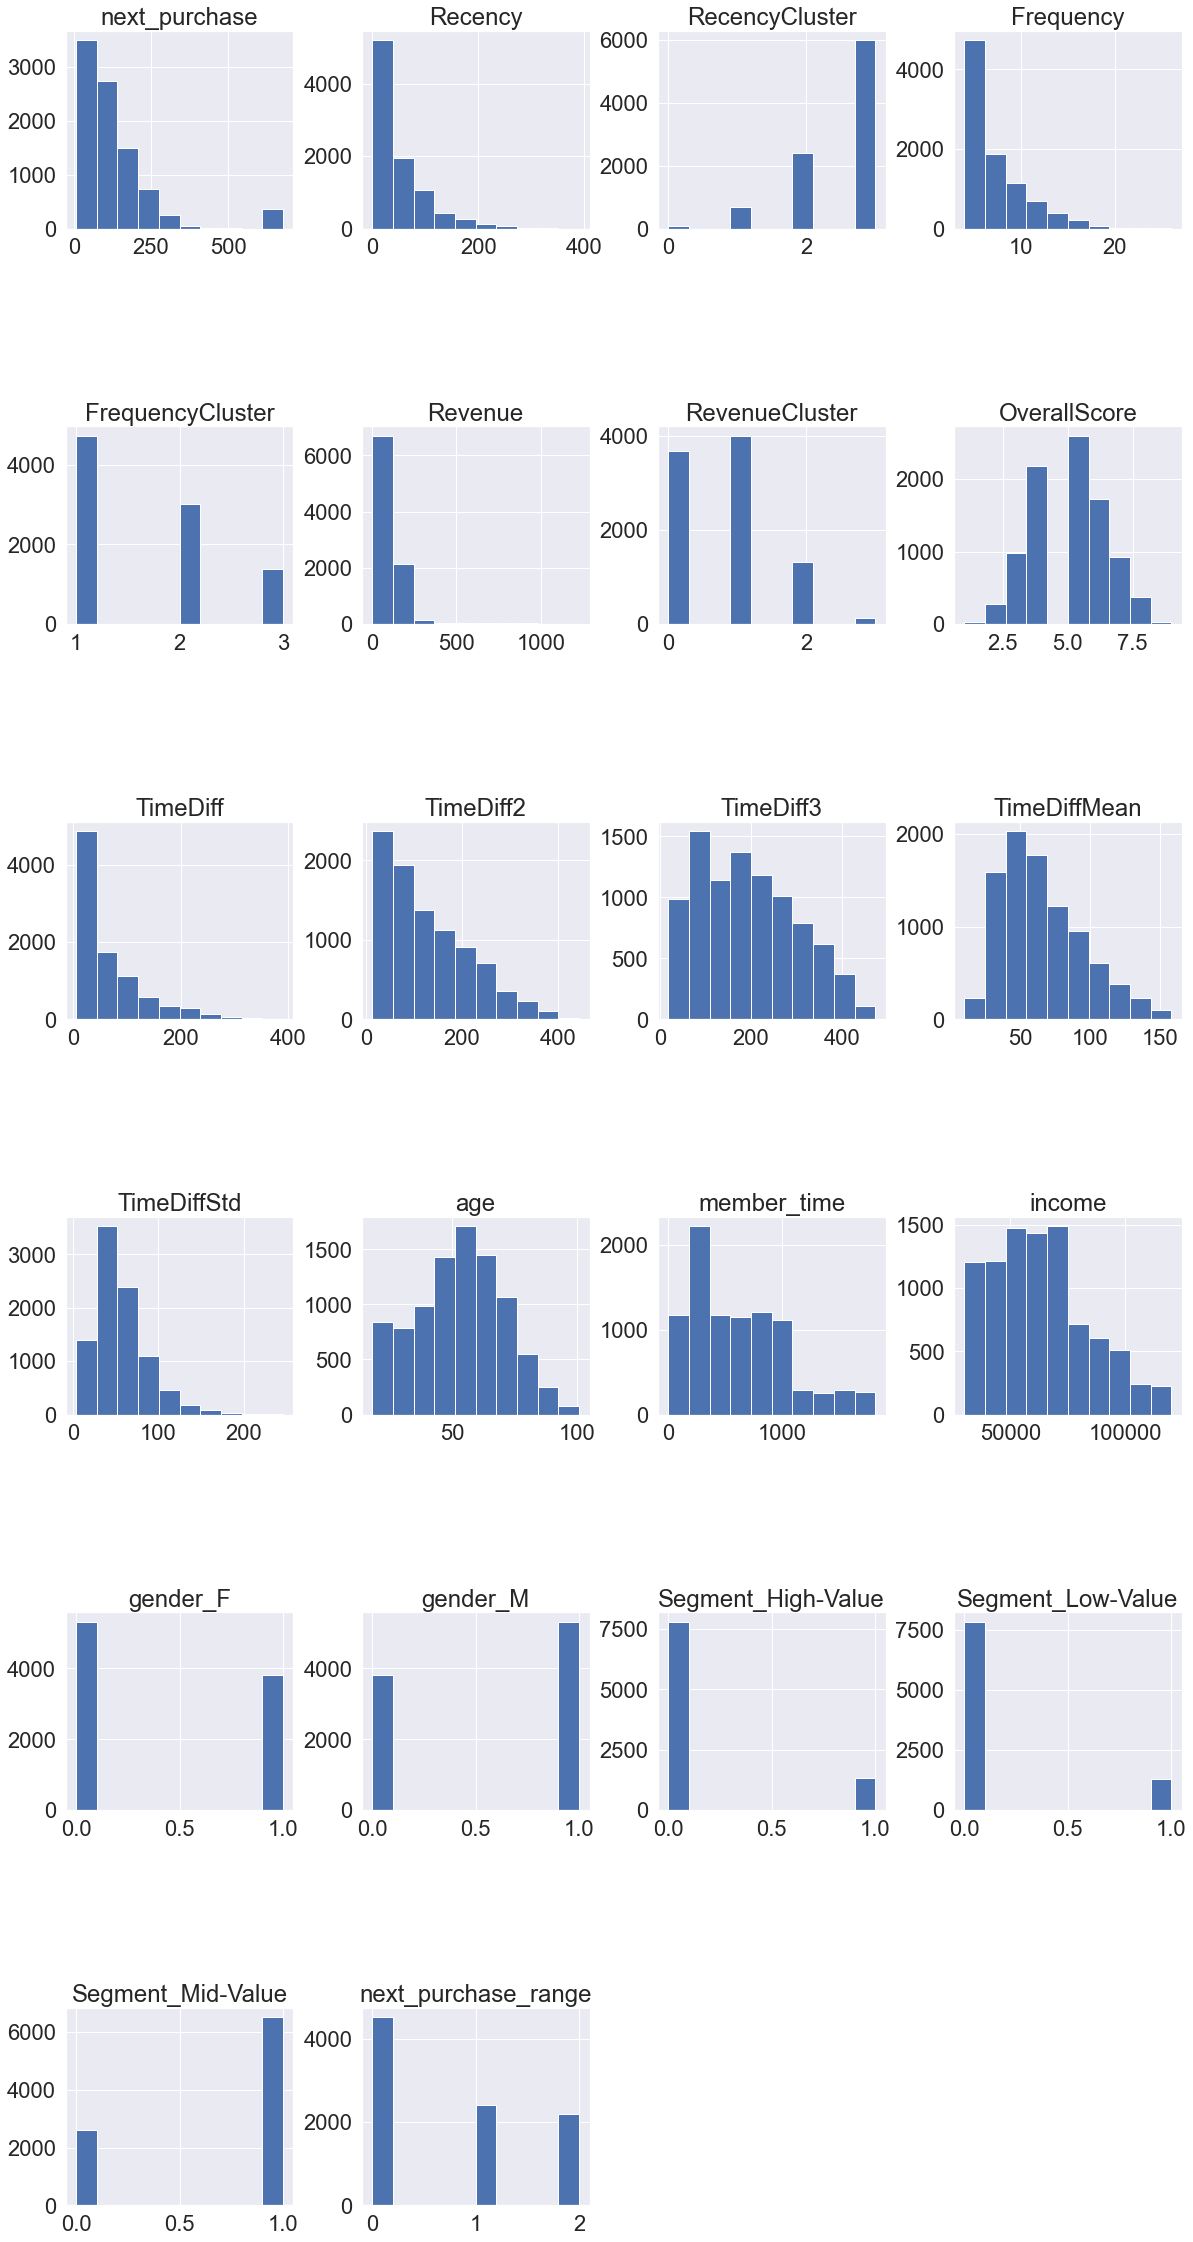

In [37]:
sb_class.hist(layout=(6, 4), figsize=(20,40), bins = 10)
plt.subplots_adjust(hspace=1)
plt.show()

# Close-up on next_purchase
It looks like we have more than 2500 customers in the second-highest bin, between about 50 and 125 hours. The range for Class 1 currently is 48-96. Maybe our target variable should follow this distribution a little more?

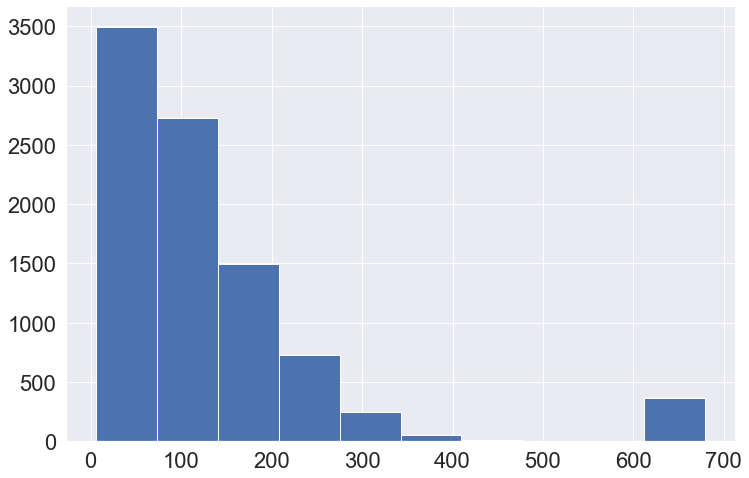

In [38]:
plt.hist(sb_class['next_purchase'], bins = 10);

# Balancing the classes
Currently, the 0 class (more than 96 hours) has almost twice as many samples as the 1 class (48-96 hours). So let's change the 1 class to 48-120 hours and see if it helps our model.

In [39]:
sb_class['next_purchase_range'].value_counts()

0    4522
1    2421
2    2187
Name: next_purchase_range, dtype: int64

In [40]:
sb_class['next_purchase_range'] = 2 #within 48 hours
sb_class.loc[sb_class.next_purchase>48,'next_purchase_range'] = 1 #within 120 hours (3-5 days)
sb_class.loc[sb_class.next_purchase>120,'next_purchase_range'] = 0 #more than 120 hours

In [41]:
sb_class['next_purchase_range'].value_counts()

0    3520
1    3423
2    2187
Name: next_purchase_range, dtype: int64

In [42]:
sb_class.drop(columns = ['next_purchase'], inplace = True)

In [43]:
sb_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9130 entries, 0 to 9129
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   person               9130 non-null   object 
 1   Recency              9130 non-null   int64  
 2   RecencyCluster       9130 non-null   int64  
 3   Frequency            9130 non-null   int64  
 4   FrequencyCluster     9130 non-null   int64  
 5   Revenue              9130 non-null   float64
 6   RevenueCluster       9130 non-null   int64  
 7   OverallScore         9130 non-null   int64  
 8   TimeDiff             9130 non-null   float64
 9   TimeDiff2            9130 non-null   float64
 10  TimeDiff3            9130 non-null   float64
 11  TimeDiffMean         9130 non-null   float64
 12  TimeDiffStd          9130 non-null   float64
 13  age                  9130 non-null   int64  
 14  member_time          9130 non-null   int64  
 15  income               9130 non-null   f

# Heatmap time again

<AxesSubplot:>

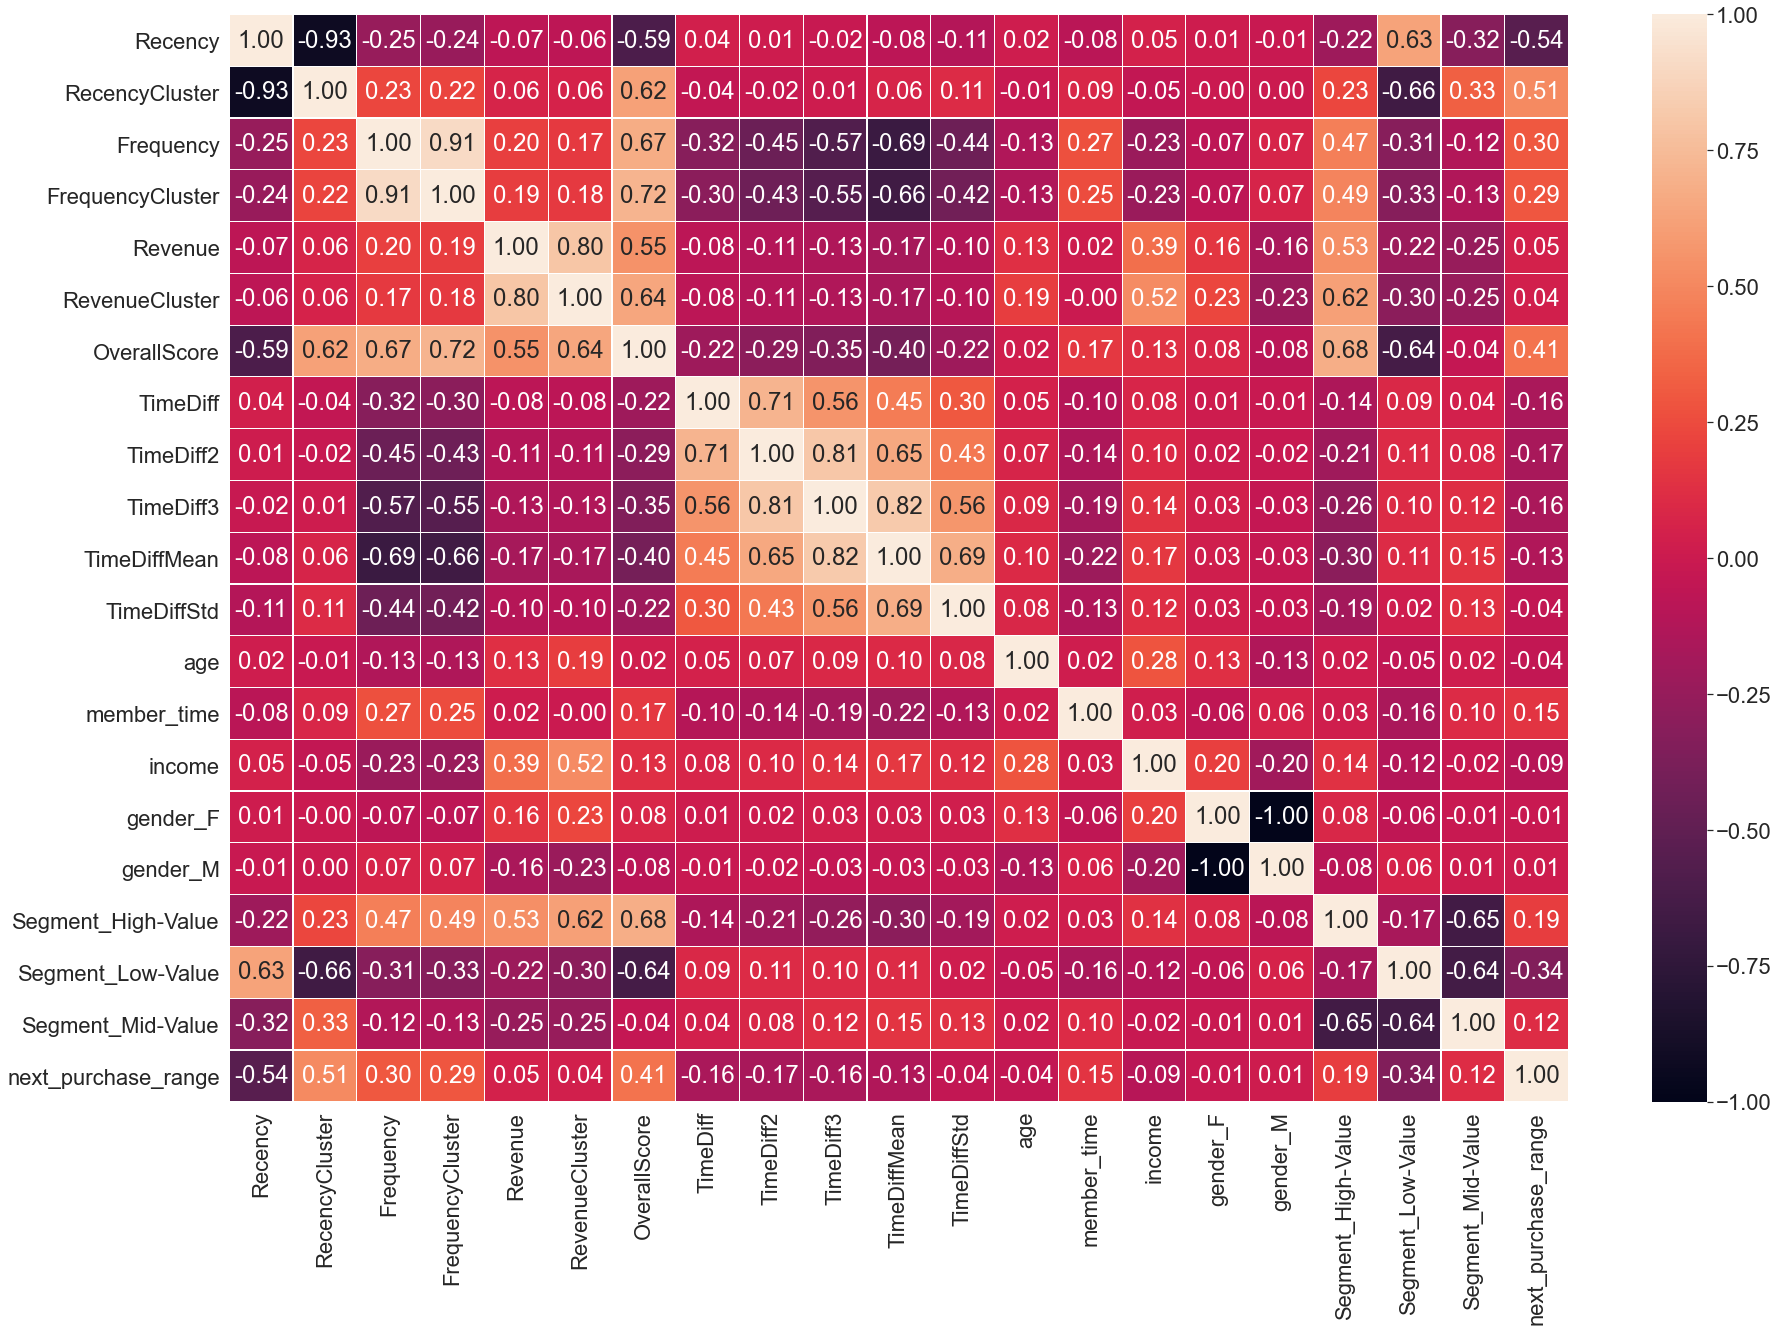

In [44]:
corr = sb_class[sb_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

Nothing looks that much different than before but let's press forward.

# Modeling

In [45]:
from sklearn.model_selection import train_test_split 

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [47]:
def make_Xy(target, df):
    X = df.drop(columns = ['person', target])
    y = df[target]
    return X, y

In [48]:
def scale(train, test):
    X_train = scaler.fit_transform(train)
    X_test = scaler.transform(test)
    return X_train, X_test

In [49]:
X, y = make_Xy('next_purchase_range', sb_class)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [51]:
X_train, X_test = scale(X_train, X_test)

In [52]:
X_scaled_df = pd.DataFrame(X_train, columns = X.columns)

In [53]:
X_scaled_df.head(10)

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,TimeDiff,TimeDiff2,TimeDiff3,TimeDiffMean,TimeDiffStd,age,member_time,income,gender_F,gender_M,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,-0.936509,0.655437,4.330337,1.868422,-0.135200,0.309990,1.434385,-0.919887,-1.311438,-1.423161,-1.504283,-1.143378,-0.448961,0.552230,0.486453,-0.844089,0.844089,2.423230,-0.405375,-1.57751
1,-0.476142,0.655437,-0.079398,0.500913,-0.414501,-1.040484,0.024270,-0.144920,0.205595,-0.177942,-0.149505,-0.637902,0.397626,0.042158,-1.475825,-0.844089,0.844089,-0.412672,-0.405375,0.63391
2,-0.245959,0.655437,-0.709360,-0.866595,-0.364203,-1.040484,-0.680787,2.567464,1.446803,1.576686,1.375053,0.979725,0.454066,-0.952132,-0.901500,-0.844089,0.844089,-0.412672,-0.405375,0.63391
3,0.789866,-0.838997,0.865545,0.500913,0.035220,0.309990,0.024270,0.630047,-0.139185,-0.574148,-0.900234,-0.402499,-1.803501,1.584129,-0.805779,-0.844089,0.844089,-0.412672,-0.405375,0.63391
4,-0.476142,0.655437,0.550564,0.500913,-0.710764,-1.040484,0.024270,-0.532403,-0.897701,-0.630749,-0.392048,0.606833,0.736261,0.241956,-0.757919,-0.844089,0.844089,-0.412672,-0.405375,0.63391
5,-0.361050,0.655437,-0.394379,-0.866595,-0.414599,-1.040484,-0.680787,-0.726145,-1.173526,-0.517547,0.605844,1.748280,-1.577745,0.636851,-0.710058,-0.844089,0.844089,-0.412672,-0.405375,0.63391
6,1.020050,-0.838997,-0.394379,-0.866595,-0.770431,-1.040484,-1.385844,-0.048049,-0.346053,-0.064740,-0.142575,-0.669472,0.115431,0.881309,-0.470756,1.184709,-1.184709,-0.412672,2.466853,-1.57751
7,-0.591234,0.655437,-0.709360,-0.866595,-0.448526,-1.040484,-0.680787,2.276851,1.377847,0.897475,1.427027,0.806297,-1.859941,-0.785242,-0.805779,1.184709,-1.184709,-0.412672,-0.405375,0.63391
8,-0.130867,0.655437,-0.079398,0.500913,-0.183427,0.309990,0.729328,-0.823016,-1.173526,0.218265,-0.010909,0.683536,0.454066,0.481713,-1.045082,-0.844089,0.844089,-0.412672,-0.405375,0.63391
9,-0.015775,0.655437,-0.709360,-0.866595,-0.206308,0.309990,0.024270,1.501885,0.688287,0.048462,-0.288101,0.380337,-1.972819,0.629799,-0.662198,-0.844089,0.844089,-0.412672,-0.405375,0.63391


In [54]:
X_scaled_df.mean()

Recency              -4.795448e-17
RecencyCluster        3.050812e-16
Frequency            -2.541474e-16
FrequencyCluster     -3.055676e-17
Revenue              -1.012768e-16
RevenueCluster        4.176235e-16
OverallScore         -3.381568e-16
TimeDiff             -2.051463e-16
TimeDiff2             1.136194e-16
TimeDiff3             8.242854e-17
TimeDiffMean         -5.760444e-17
TimeDiffStd          -1.811170e-16
age                  -2.153739e-16
member_time          -2.536263e-17
income                1.643881e-16
gender_F              9.592633e-17
gender_M             -9.592633e-17
Segment_High-Value    2.653174e-16
Segment_Low-Value     3.935116e-16
Segment_Mid-Value    -5.317293e-16
dtype: float64

In [55]:
X_scaled_df.std()

Recency               1.000078
RecencyCluster        1.000078
Frequency             1.000078
FrequencyCluster      1.000078
Revenue               1.000078
RevenueCluster        1.000078
OverallScore          1.000078
TimeDiff              1.000078
TimeDiff2             1.000078
TimeDiff3             1.000078
TimeDiffMean          1.000078
TimeDiffStd           1.000078
age                   1.000078
member_time           1.000078
income                1.000078
gender_F              1.000078
gender_M              1.000078
Segment_High-Value    1.000078
Segment_Low-Value     1.000078
Segment_Mid-Value     1.000078
dtype: float64

In [56]:
model_lists = []

In [57]:
def show_report(df):
    for i in range(3):
        precision = df.loc['precision', str(i)]
        recall = df.loc['recall', str(i)]
        f1score = df.loc['f1-score', str(i)]
        print()
        print(i, " class:")
        print(f"Precision: {precision:.5f}")
        print(f"Recall: {recall:.5f}")
        print(f"F1 Score: {f1score:.5f}")

# Reminder of errors we most want to avoid
Since the classes are a little different now, an updated ranking of the errors we most want to avoid:<br>

**Class 2 predicted as Class 0:** Customers who will come back in 2 days predicted as not coming back until at least 5 days.<br>
**Class 1 predicted as Class 0:** Customers who will come back in 3-5 days predicted as not coming back until at least 5 days.<br>
**Class 2 predicted as Class 1:** Customers who will come back in 2 days predicted as coming back in 3-5 days.<br>

In [58]:
def list_to_append(model, acc, df, c_matrix):
    new_list = []
    new_list.append(model)
    new_list.append(round(acc, 5))
    for i in range(3):
        new_list.append(round(df.loc['precision', str(i)], 5))
        new_list.append(round(df.loc['recall', str(i)], 5))
        new_list.append(round(df.loc['f1-score', str(i)], 5))
    new_list.append(round(c_matrix[2, 0], 5))
    new_list.append(round(c_matrix[1, 0], 5))
    new_list.append(round(c_matrix[2, 1], 5))
    return new_list

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [60]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.5772179627601315


0  class:
Precision: 0.71230
Recall: 0.62949
F1 Score: 0.66834

1  class:
Precision: 0.49519
Recall: 0.49662
F1 Score: 0.49591

2  class:
Precision: 0.52356
Recall: 0.62112
F1 Score: 0.56818


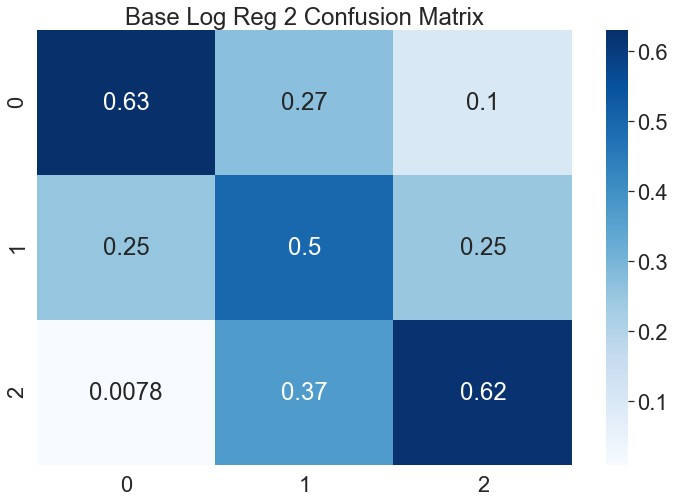

In [62]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
clf_cmatrix = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(clf_cmatrix, annot=True, cmap = 'Blues').set(title = 'Base Log Reg 2 Confusion Matrix');

In [63]:
new_list = list_to_append('Base Logistic Regression 2', acc, report_df, clf_cmatrix)

In [64]:
model_lists.append(new_list)

In [65]:
model_lists

[['Base Logistic Regression 2',
  0.57722,
  0.7123,
  0.62949,
  0.66834,
  0.49519,
  0.49662,
  0.49591,
  0.52356,
  0.62112,
  0.56818,
  0.00776,
  0.25458,
  0.37112]]

# Good news and bad news
The bad news is we're sacrificing a little bit of accuracy but the good news is every precision and recall score is at least 50 percent.

In [66]:
#from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [67]:
param_grid = {"C": [0.001, 0.1, 1, 10, 100]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train, y_train) 
logreg_cv.best_params_

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'C': 10}

In [68]:
logreg_cv.best_score_

0.5848851251895003

In [69]:
best_clsfr = LogisticRegression(C=10)
best_clsfr.fit(X_train, y_train)
y_pred = best_clsfr.predict(X_test)

In [70]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.5768528660094925


0  class:
Precision: 0.71047
Recall: 0.62854
F1 Score: 0.66700

1  class:
Precision: 0.49517
Recall: 0.49470
F1 Score: 0.49493

2  class:
Precision: 0.52412
Recall: 0.62422
F1 Score: 0.56981


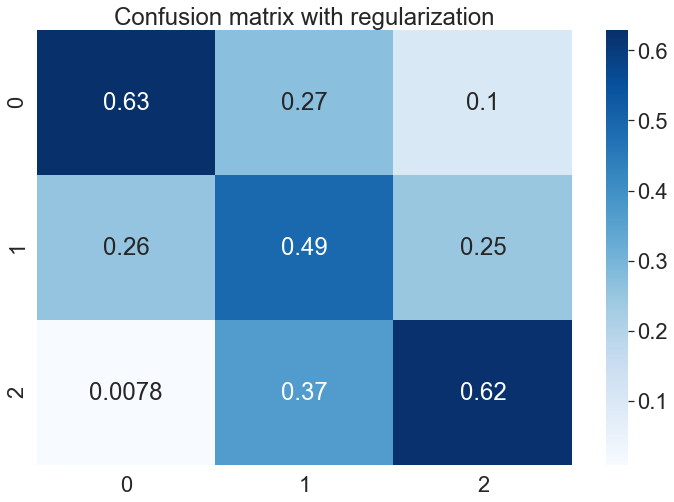

In [71]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
best_clsfr_cmatrix = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(best_clsfr_cmatrix, annot=True, cmap = 'Blues').set(title = 'Confusion matrix with regularization');

In [72]:
new_list = list_to_append('Tuned Logistic Regression 2', acc, report_df, best_clsfr_cmatrix)
model_lists.append(new_list)

# Basically the same
On to Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier
base_rf = RandomForestClassifier(random_state = 42)
base_rf.fit(X_train, y_train)
y_pred = base_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc:.5f}")

Accuracy score: 0.58671


In [74]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.5867104782767434


0  class:
Precision: 0.69745
Recall: 0.62098
F1 Score: 0.65700

1  class:
Precision: 0.52498
Recall: 0.53713
F1 Score: 0.53098

2  class:
Precision: 0.53397
Recall: 0.61025
F1 Score: 0.56957


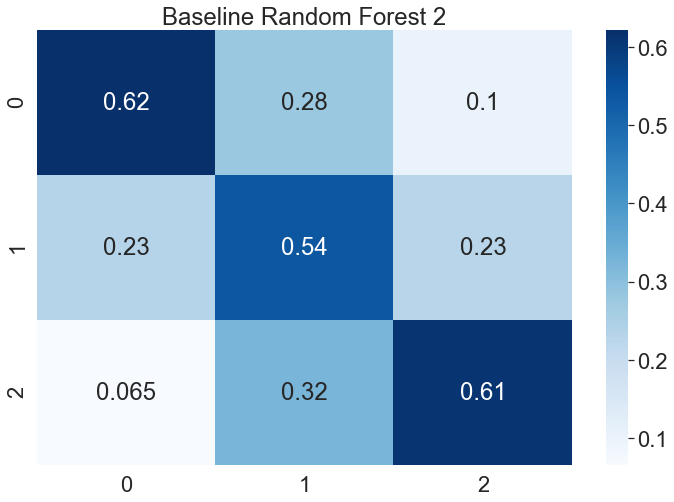

In [75]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
base_rf_cmatrix = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(base_rf_cmatrix, annot=True, cmap = 'Blues').set(title = 'Baseline Random Forest 2');

In [76]:
new_list = list_to_append('Base Random Forest 2', acc, report_df, base_rf_cmatrix)
model_lists.append(new_list)

# Decisions, decisions
No matter what decision trees do, it's humans who ultimately have to make the big decisions. Our baseline Random Forest does a little bit better learning Class 1 we but sacrifice a little with Class 2. The True 2-Predicted 0 error, the one we want to avoid the most, was less than 1 percent with LogReg, but it's up to 7 percent here. Let's do some hyperparameter tuning.


In [77]:
param_grid = {'n_estimators' : [50, 100, 200], 'max_depth' : [3, 6, 9], 'max_features': ['auto', 'sqrt'],\
             'min_samples_split': [6], 'min_samples_leaf':[1, 2, 3, 4, 5]}

In [78]:
#from sklearn.model_selection import RandomizedSearchCV
tuned_rf = RandomForestClassifier(random_state = 42)
rand_grid = GridSearchCV(tuned_rf, param_grid, cv = 3, n_jobs = 2, verbose = 3)
rand_grid.fit(X_train, y_train)
print(f"Best Accuracy: {rand_grid.best_score_:.5f}")
print(f"Best Params: {rand_grid.best_params_}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   48.4s
[Parallel(n_jobs=2)]: Done 270 out of 270 | elapsed:  2.4min finished


Best Accuracy: 0.59443
Best Params: {'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 200}


In [79]:
best_rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 6, min_samples_leaf = 5,\
                                 max_features = 'auto', max_depth = 9, random_state = 42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
best_rf_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {best_rf_acc:.5f}")

Accuracy score: 0.59985


In [80]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.5998539612997444


0  class:
Precision: 0.73923
Recall: 0.61626
F1 Score: 0.67216

1  class:
Precision: 0.53582
Recall: 0.52652
F1 Score: 0.53113

2  class:
Precision: 0.53103
Recall: 0.69099
F1 Score: 0.60054


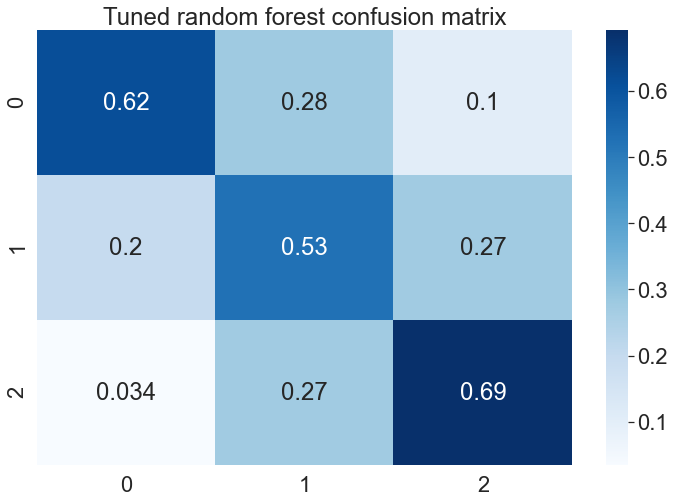

In [81]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
best_rf_mtx = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(best_rf_mtx, annot=True, cmap = 'Blues').set(title = 'Tuned random forest confusion matrix');

In [82]:
new_list = list_to_append('Tuned Random Forest 2', acc, report_df, best_rf_mtx)
model_lists.append(new_list)

# The best so far
Recall for Class 2 goes from 62 to 69 percent and while recall stays at 53 percent for Class 1, the T1P0 errors go from 23 to 20 percent. We have more errors where Class 1 customers are predicted as Class 2, but that would just mean that more people get an offer three days early if they don't buy within the expected time frame.<br>

Just out of curiosity let's see what Naive Bayes does. We didn't even bother collecting the metrics the last time.

In [83]:
from sklearn.naive_bayes import GaussianNB

In [84]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [85]:
print("Naive Bayes score: ",nb.score(X_test, y_test))

Naive Bayes score:  0.4874041621029573


49 percent accuracy. Moving right along ...

# XGBoost

In [86]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier(random_state = 42)
xgb_class.fit(X_train, y_train)
y_pred = xgb_class.predict(X_test)
print("Accuracy on training set:", xgb_class.score(X_train, y_train))
print("Accuracy on test set:", xgb_class.score(X_test, y_test))

C:\Users\Owner\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set: 0.969644813018307
Accuracy on test set: 0.5640744797371303


In [87]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.5640744797371303


0  class:
Precision: 0.67834
Recall: 0.60397
F1 Score: 0.63900

1  class:
Precision: 0.49355
Recall: 0.51688
F1 Score: 0.50495

2  class:
Precision: 0.52039
Recall: 0.57453
F1 Score: 0.54613


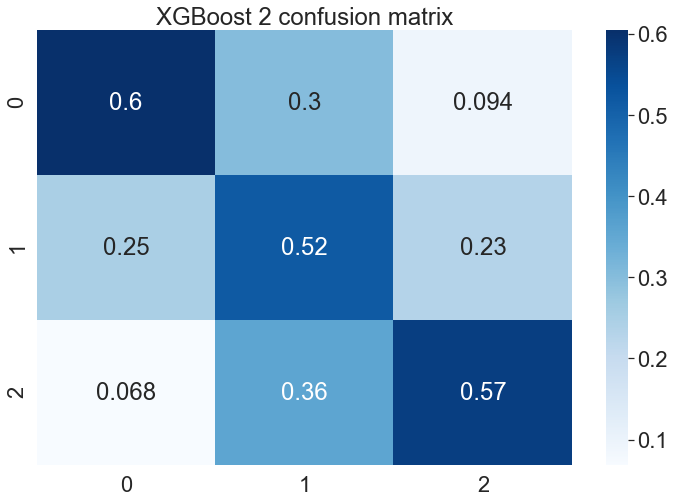

In [88]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
xgbclass_mtx = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(xgbclass_mtx, annot=True, cmap = 'Blues').set(title = 'XGBoost 2 confusion matrix');

In [89]:
new_list = list_to_append('Base XG Boost 2', acc, report_df, xgbclass_mtx)
model_lists.append(new_list)

# Tuned Random Forest still leads
We'll have to do some tuning.

In [90]:
xgb_params = {'learning_rate' : [0.01, 0.1, 0.5], 'max_depth': [6, 7, 8, 9], 'colsample_bytree': [0.5, 1],\
             'n_estimators': [100, 125, 150, 175, 200, 225, 250]}

In [91]:
# tuned_xgb = xgb.XGBClassifier(random_state = 42)
# xgb_cv = GridSearchCV(tuned_xgb, xgb_params, cv = 3, n_jobs = 2, verbose = 3)
# xgb_cv.fit(X_train, y_train)
# print(f"Best Accuracy: {xgb_cv.best_score_:.5f}")
# print(f"Best Params: {xgb_cv.best_params_}")

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   41.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  9.7min
[Parallel(n_jobs=2)]: Done 504 out of 504 | elapsed: 19.6min finished
C:\Users\Owner\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Accuracy: 0.59505
Best Params: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 150}


In [92]:
best_xgb = xgb.XGBClassifier(n_estimators = 150, max_depth = 6, learning_rate = 0.01, colsample_bytree = 1)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print("Accuracy on training set:", best_xgb.score(X_train, y_train))
print("Accuracy on test set:", best_xgb.score(X_test, y_test))

[17:50:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set: 0.6693788139571272
Accuracy on test set: 0.5932822197882439


In [93]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)

Accuracy score:
0.5932822197882439


0  class:
Precision: 0.73227
Recall: 0.60491
F1 Score: 0.66253

1  class:
Precision: 0.53924
Recall: 0.51688
F1 Score: 0.52782

2  class:
Precision: 0.51550
Recall: 0.69720
F1 Score: 0.59274


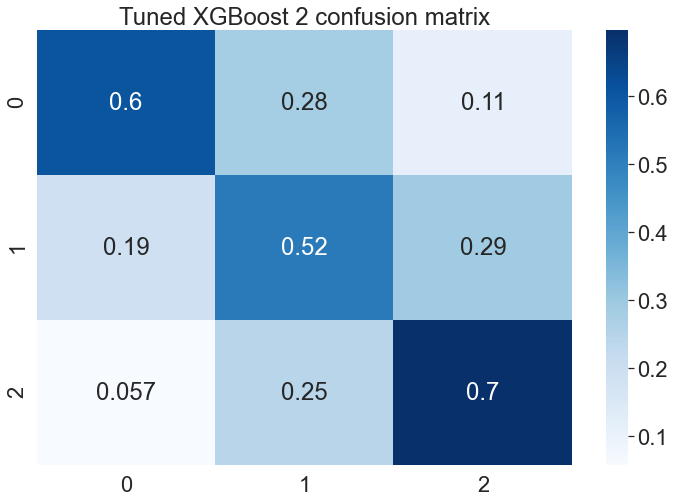

In [94]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
bestxgb_mtx = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(bestxgb_mtx, annot=True, cmap = 'Blues').set(title = 'Tuned XGBoost 2 confusion matrix');

In [95]:
new_list = list_to_append('Tuned XG Boost 2', acc, report_df, bestxgb_mtx)
model_lists.append(new_list)

# It's going to be close
We'll have to look at the dataframe to be sure but at first glance it looks like Tuned Random Forest is better than tuned XG Boost.

# Let's try K Nearest Neighbors

In [96]:
from sklearn.neighbors import KNeighborsClassifier

In [97]:
param_grid = {'n_neighbors': np.arange(1,51)}

In [98]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=3, n_jobs = 2, verbose = 3)
knn_cv.fit(X_train, y_train)
print(f"Best Accuracy: {knn_cv.best_score_:.5f}")
print(f"Best Params: {knn_cv.best_params_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   43.9s


Best Accuracy: 0.54233
Best Params: {'n_neighbors': 50}


[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   55.0s finished


In [99]:
tuned_knn = KNeighborsClassifier(n_neighbors = 50)
tuned_knn.fit(X_train, y_train)
y_pred = tuned_knn.predict(X_test)
print("Accuracy on training set:", tuned_knn.score(X_train, y_train))
print("Accuracy on test set:", tuned_knn.score(X_test, y_test))

Accuracy on training set: 0.5703332811766547
Accuracy on test set: 0.5571376414749909


In [100]:
report = classification_report(y_test, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:")
print(acc)
print()
show_report(report_df)


Accuracy score:
0.5571376414749909


0  class:
Precision: 0.68757
Recall: 0.61153
F1 Score: 0.64732

1  class:
Precision: 0.47631
Recall: 0.53327
F1 Score: 0.50318

2  class:
Precision: 0.51177
Recall: 0.50621
F1 Score: 0.50898


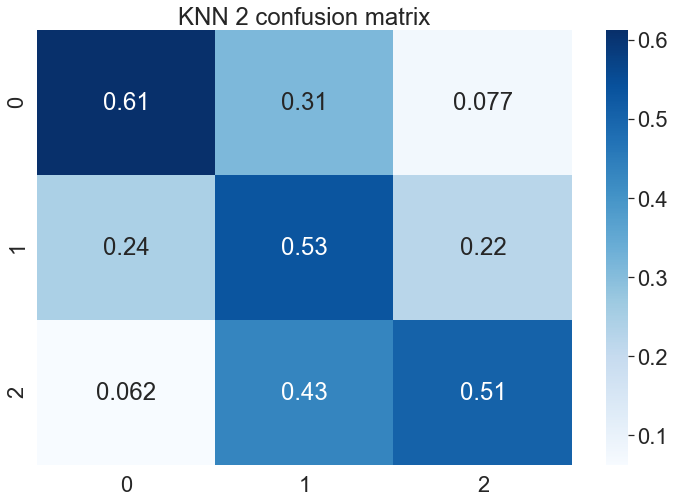

In [101]:
sns.set(rc = {'figure.figsize':(12,8)}, font_scale = 2)
knn_mtx = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(knn_mtx, annot=True, cmap = 'Blues').set(title = 'KNN 2 confusion matrix');

In [102]:
new_list = list_to_append('K Nearest Neighbors 2', acc, report_df, knn_mtx)
model_lists.append(new_list)

# No good
Looks like it's going to come down to Random Forest and Tuned XG Boost

# Dataframe of model results
Let's start by bringing in the models from Part 1

In [103]:
models_df = pd.read_csv('models_df1.csv')

In [104]:
models_df

,Unnamed: 0,Model,Accuracy,0 Precision,0 Recall,0 F1 Score,1 Precision,1 Recall,1 F1 Score,2 Precision,2 Recall,2 F1 Score,T2P0,T1P0,T2P1
0,0,Base Logistic Regression,0.60204,0.69685,0.78319,0.73750,0.39931,0.15562,0.22395,0.50917,0.73292,0.60089,0.13820,0.50474,0.12888
1,1,Tuned Logistic Regression,0.60204,0.69685,0.78319,0.73750,0.39931,0.15562,0.22395,0.50917,0.73292,0.60089,0.13820,0.50474,0.12888
2,2,Base Random Forest,0.59657,0.70914,0.75516,0.73143,0.40343,0.25440,0.31203,0.50905,0.65528,0.57298,0.16149,0.42760,0.18323
3,3,Tuned Random Forest,0.60606,0.71036,0.76327,0.73587,0.44199,0.21651,0.29064,0.50543,0.72205,0.59463,0.16149,0.43031,0.11646
4,4,Base XG Boost,0.58050,0.69376,0.73009,0.71146,0.38776,0.28281,0.32707,0.50582,0.60714,0.55187,0.18634,0.42896,0.20652
5,5,Tuned XG Boost,0.61665,0.71158,0.77507,0.74197,0.46216,0.23139,0.30839,0.52354,0.72516,0.60807,0.16615,0.43166,0.10870
6,6,K Nearest Neighbors,0.57101,0.67293,0.76622,0.71655,0.37662,0.23545,0.28976,0.47885,0.54503,0.50980,0.24845,0.46685,0.20652


In [105]:
models_df2 = pd.DataFrame(model_lists, columns = ['Model', 'Accuracy', '0 Precision', '0 Recall', '0 F1 Score',\
                                                '1 Precision', '1 Recall', '1 F1 Score',\
                                                '2 Precision', '2 Recall', '2 F1 Score',\
                                                'T2P0', 'T1P0', 'T2P1'])

In [106]:
models_df2

,Model,Accuracy,0 Precision,0 Recall,0 F1 Score,1 Precision,1 Recall,1 F1 Score,2 Precision,2 Recall,2 F1 Score,T2P0,T1P0,T2P1
0,Base Logistic Regression 2,0.57722,0.71230,0.62949,0.66834,0.49519,0.49662,0.49591,0.52356,0.62112,0.56818,0.00776,0.25458,0.37112
1,Tuned Logistic Regression 2,0.57685,0.71047,0.62854,0.66700,0.49517,0.49470,0.49493,0.52412,0.62422,0.56981,0.00776,0.25651,0.36801
2,Base Random Forest 2,0.58671,0.69745,0.62098,0.65700,0.52498,0.53713,0.53098,0.53397,0.61025,0.56957,0.06522,0.23433,0.32453
3,Tuned Random Forest 2,0.59985,0.73923,0.61626,0.67216,0.53582,0.52652,0.53113,0.53103,0.69099,0.60054,0.03416,0.20058,0.27484
4,Base XG Boost 2,0.56407,0.67834,0.60397,0.63900,0.49355,0.51688,0.50495,0.52039,0.57453,0.54613,0.06832,0.24976,0.35714
5,Tuned XG Boost 2,0.59328,0.73227,0.60491,0.66253,0.53924,0.51688,0.52782,0.51550,0.69720,0.59274,0.05745,0.18997,0.24534
6,K Nearest Neighbors 2,0.55714,0.68757,0.61153,0.64732,0.47631,0.53327,0.50318,0.51177,0.50621,0.50898,0.06211,0.24494,0.43168


In [107]:
models_df.drop(columns = ['Unnamed: 0'], inplace = True)

In [108]:
models_df = pd.concat([models_df, models_df2])

In [109]:
models_df

,Model,Accuracy,0 Precision,0 Recall,0 F1 Score,1 Precision,1 Recall,1 F1 Score,2 Precision,2 Recall,2 F1 Score,T2P0,T1P0,T2P1
0,Base Logistic Regression,0.60204,0.69685,0.78319,0.73750,0.39931,0.15562,0.22395,0.50917,0.73292,0.60089,0.13820,0.50474,0.12888
1,Tuned Logistic Regression,0.60204,0.69685,0.78319,0.73750,0.39931,0.15562,0.22395,0.50917,0.73292,0.60089,0.13820,0.50474,0.12888
2,Base Random Forest,0.59657,0.70914,0.75516,0.73143,0.40343,0.25440,0.31203,0.50905,0.65528,0.57298,0.16149,0.42760,0.18323
3,Tuned Random Forest,0.60606,0.71036,0.76327,0.73587,0.44199,0.21651,0.29064,0.50543,0.72205,0.59463,0.16149,0.43031,0.11646
4,Base XG Boost,0.58050,0.69376,0.73009,0.71146,0.38776,0.28281,0.32707,0.50582,0.60714,0.55187,0.18634,0.42896,0.20652
5,Tuned XG Boost,0.61665,0.71158,0.77507,0.74197,0.46216,0.23139,0.30839,0.52354,0.72516,0.60807,0.16615,0.43166,0.10870
6,K Nearest Neighbors,0.57101,0.67293,0.76622,0.71655,0.37662,0.23545,0.28976,0.47885,0.54503,0.50980,0.24845,0.46685,0.20652
0,Base Logistic Regression 2,0.57722,0.71230,0.62949,0.66834,0.49519,0.49662,0.49591,0.52356,0.62112,0.56818,0.00776,0.25458,0.37112
1,Tuned Logistic Regression 2,0.57685,0.71047,0.62854,0.66700,0.49517,0.49470,0.49493,0.52412,0.62422,0.56981,0.00776,0.25651,0.36801
2,Base Random Forest 2,0.58671,0.69745,0.62098,0.65700,0.52498,0.53713,0.53098,0.53397,0.61025,0.56957,0.06522,0.23433,0.32453


# Let's narrow this down
We know that the winning model will come from the second wave, where we widen the Class 1 bucket to 3-5 days, because we have no precision scores for Class 1 above 46 percent and no recall scores for Class 1 above 28 percent in the first wave. So let's drop the first wave from the dataframe.

In [118]:
models_df = models_df.iloc[7:, :]

In [119]:
models_df

,Model,Accuracy,0 Precision,0 Recall,0 F1 Score,1 Precision,1 Recall,1 F1 Score,2 Precision,2 Recall,2 F1 Score,T2P0,T1P0,T2P1
0,Base Logistic Regression 2,0.57722,0.71230,0.62949,0.66834,0.49519,0.49662,0.49591,0.52356,0.62112,0.56818,0.00776,0.25458,0.37112
1,Tuned Logistic Regression 2,0.57685,0.71047,0.62854,0.66700,0.49517,0.49470,0.49493,0.52412,0.62422,0.56981,0.00776,0.25651,0.36801
2,Base Random Forest 2,0.58671,0.69745,0.62098,0.65700,0.52498,0.53713,0.53098,0.53397,0.61025,0.56957,0.06522,0.23433,0.32453
3,Tuned Random Forest 2,0.59985,0.73923,0.61626,0.67216,0.53582,0.52652,0.53113,0.53103,0.69099,0.60054,0.03416,0.20058,0.27484
4,Base XG Boost 2,0.56407,0.67834,0.60397,0.63900,0.49355,0.51688,0.50495,0.52039,0.57453,0.54613,0.06832,0.24976,0.35714
5,Tuned XG Boost 2,0.59328,0.73227,0.60491,0.66253,0.53924,0.51688,0.52782,0.51550,0.69720,0.59274,0.05745,0.18997,0.24534
6,K Nearest Neighbors 2,0.55714,0.68757,0.61153,0.64732,0.47631,0.53327,0.50318,0.51177,0.50621,0.50898,0.06211,0.24494,0.43168


# The winner: Tuned Random Forest
Tuned Random Forest has the best accuracy and the best F1 scores for all three classes, and it has the second-lowest error percentage for each of the three errors we most want to avoid in the confusion matrix.

# Business plan
We can use this model to track our usage of discount and buy-one-get-one offers.<br>
Customers in Class 2 will receive an offer if they don't make their next purchase within 48 hours.<br>
Customers in Class 1 will receive an offer if they don't make their next purchase within 120 hours.<br>
Customers in Class 0 will receive an offer if they don't make their next purchase within two weeks (although this timeline is a little more open-ended.)<br>